In [80]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.io import arff
import pandas as pd
from sklearn.decomposition import PCA
import time
import lime
import shap
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


<br></br>
<left><font size="+3">DDoS Dataset</font></left>
<br></br>



## Aim and Information about the Dataset

The aim would be to train a classifier able to discrimanate between a normal type of network behaviour from malicious <a href = "https://www.cloudflare.com/learning/ddos/what-is-a-ddos-attack/" target = "_self">__DDoS attacks__</a>. In the dataset are included four types of attacks flows   <a href = "https://en.wikipedia.org/wiki/UDP_flood_attack" target = "_self">'UDP-Flood'</a>,  <a href = "https://en.wikipedia.org/wiki/Smurf_attack" target = "_self">'Smurf'</a>,  'SIDDOS', <a href = "https://www.cloudflare.com/learning/ddos/http-flood-ddos-attack/" target = "_self"> 'HTTP-FLOOD'</a> but I will train a binary classification able to classify between normal and malicious traffic network and to do so, I will merge the four types of malicious attacks in one. At the end of the training phase, I have added a section to explain the outcome of the classification model using two Explainable AI models, SHAP that can give a Local and Global explaination and LIME which is only for Local explaination. 

### Steps:
<ul>
    <li> <b>1. Load the DDoS dataset</b></li>
    <ul>
       <li>1.1 Fix loading problems</li>
    </ul>
    <br>
<li><b> 2. EDA</b></li>
     <ul>
         <li>2.1 Check for missing values and duplicates</li>
         <li>2.2 Create dummies columns for FLAGS feature</li>
         <li>2.2 Check for highly correlated features</li>
          <li>2.2.1 Drop highly correlated features</li>
           <li>2.3 Data Visualization</li>
           <li>2.3.1 Scale the features to plot them</li>
           <li>2.3.2 Pairwise Plots <b>(IT CANNOT BE RUN HERE)</b></li>
           <li>2.3.3 Plot Outliners</li>
           <li>2.3.4 PCA Scatter Plot <b>(IT CANNOT BE RUN HERE)</b></li>
         <li>2.4 Check for highly correlated features</li>
          <li>2.2.1 Drop highly correlated features</li>
        </ul>
    <br>
<li><b> 3. Preparing the dataset for the training</b></li>
    <ul>
       <li>3.1 Check if the data is unbalanced</li>
       <li>3.2 Merge Malicious Flows in one category</li>
       <li>3.3 Split the dataset in two sets</li>
       <li>3.4 SMOTE technique to balance the train dataset</li>
       <li>3.5 Split the train dataset for validation use</li>
      </ul>
    <br>
<li><b> 4. Test Harness with Cross Validation</b></li>
    <ul>
       <li>4.1 Pipelines of learning algorithms</li>
       <li>4.2 Spot-check the best model using Box and Whiskers Plots</li>
       </ul>
    <br>
<li><b> 5. Training phase</b></li>
    <ul>
       <li>5.1 Train the best learning algorithm</li>
        <li>5.1.1 Traing without tuning the parameters</li>     
        <li>5.2 Tune the hyperparameters of the learning algorithm</li>
        <li>5.2.1 Random Search CV to find the best hyperparameters</li>
        <li>5.3 Traing with the tuned the parameters</li>
    </ul>
    <br>
    <li><b> 6. XAI</b></li>
    <ul>
        <li>6.1 SHAP</li>
        <li>6.1.1 SHAP Global Explaination</li>
        <li>6.1.2 SHAP Local Explaination</li>
        <li>6.2 LIME</li>
        <li>6.2.1 LIME Local Explaination</li>
    </ul>



# 1. Load the DDoS dataset

In [81]:
%%memit
#https://www.kaggle.com/datasets/jacobvs/ddos-attack-network-logs?select=final-dataset.arff

data, meta = arff.loadarff('/kaggle/input/ddos-attack-network-logs/final-dataset.arff')
df = pd.DataFrame(data)

peak memory: 8793.72 MiB, increment: 3303.02 MiB


In [82]:
scrapddos = pd.read_csv("/kaggle/input/ddosdata/ddosdata.csv")


__I will use for this work only a sample bacause it requires a lot computational power to train a calssificatioin on the whole dataset.__

In [83]:
df_target = df[df.columns[-1]]
df_X = df.iloc[:,:-1]

In [84]:
_, X_feature, _, y_target = train_test_split(df_X, df_target, 
                                                    test_size=0.40, random_state=2, stratify= df_target)

In [85]:
df = pd.concat([X_feature, y_target], axis=1)

In [86]:
df.head(2)

SRC_ADD  DES_ADD    PKT_ID  FROM_NODE  TO_NODE PKT_TYPE  PKT_SIZE  \
1896118    24.14     14.0  154688.0       24.0     23.0   b'ack'      55.0   
1959586    24.70      7.0    8732.0       23.0     21.0   b'tcp'      64.0   

              FLAGS   FID  SEQ_NUMBER  ...    PKT_RATE     BYTE_RATE  \
1896118  b'-------'  15.0      4821.0  ...  328.432001  18063.800000   
1959586  b'-------'   0.0        -1.0  ...   23.255775   1488.369621   

        PKT_AVG_SIZE UTILIZATION  PKT_DELAY  PKT_SEND_TIME  PKT_RESEVED_TIME  \
1896118         55.0    0.008446   0.000000      15.777890         15.807900   
1959586         64.0    0.000128   0.030015       9.108642          9.138657   

         FIRST_PKT_SENT  LAST_PKT_RESEVED  PKT_CLASS  
1896118        1.030038         50.059974  b'Normal'  
1959586        0.108642          9.138657  b'Normal'  

[2 rows x 28 columns]

In [87]:
print(f'Number of rows {df.shape[0]} and number of columns {df.shape[1]}')

Number of rows 864268 and number of columns 28


## 1.1 Fix loading problems

We can see that some of values in the cells are not correctly loaded into the dataframe. In fact, for instance, the feature <font color=red>FLAGS</font> still left encoded in bytes as it can be seen by letter 'b' starting the sequence of symbols. There are other problems related to the loading phase because some of the features that clearly should be represented by integers are now floating numbers, such as for the feature <font color=red>FROM_NODE</font>. Before wworking on the  

### I convert each rows that are in bytes into strings

In [88]:
#decode bytes sequences in strings
df = df.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)

In [89]:
df.head(2)

SRC_ADD  DES_ADD    PKT_ID  FROM_NODE  TO_NODE PKT_TYPE  PKT_SIZE  \
1896118    24.14     14.0  154688.0       24.0     23.0      ack      55.0   
1959586    24.70      7.0    8732.0       23.0     21.0      tcp      64.0   

           FLAGS   FID  SEQ_NUMBER  ...    PKT_RATE     BYTE_RATE  \
1896118  -------  15.0      4821.0  ...  328.432001  18063.800000   
1959586  -------   0.0        -1.0  ...   23.255775   1488.369621   

        PKT_AVG_SIZE UTILIZATION  PKT_DELAY  PKT_SEND_TIME  PKT_RESEVED_TIME  \
1896118         55.0    0.008446   0.000000      15.777890         15.807900   
1959586         64.0    0.000128   0.030015       9.108642          9.138657   

         FIRST_PKT_SENT  LAST_PKT_RESEVED  PKT_CLASS  
1896118        1.030038         50.059974     Normal  
1959586        0.108642          9.138657     Normal  

[2 rows x 28 columns]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864268 entries, 1896118 to 682597
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SRC_ADD           864268 non-null  float64
 1   DES_ADD           864268 non-null  float64
 2   PKT_ID            864268 non-null  float64
 3   FROM_NODE         864268 non-null  float64
 4   TO_NODE           864268 non-null  float64
 5   PKT_TYPE          864268 non-null  object 
 6   PKT_SIZE          864268 non-null  float64
 7   FLAGS             864268 non-null  object 
 8   FID               864268 non-null  float64
 9   SEQ_NUMBER        864268 non-null  float64
 10  NUMBER_OF_PKT     864268 non-null  float64
 11  NUMBER_OF_BYTE    864268 non-null  float64
 12  NODE_NAME_FROM    864268 non-null  object 
 13  NODE_NAME_TO      864268 non-null  object 
 14  PKT_IN            864268 non-null  float64
 15  PKT_OUT           864268 non-null  float64
 16  PKT_R         

### Fix some columns loaded with the wrong data type.
Some columns after loading the dataset have been loaded with a wrong data type, in fact, instead of integers in those columns now they are float numbers. With snipped code below, I convert back those columns to the right data type format. 

In [91]:
df['FROM_NODE'] = df['FROM_NODE'].apply(np.int64)
df['TO_NODE'] = df['TO_NODE'].apply(np.int64)
df['PKT_SIZE'] = df['PKT_SIZE'].apply(np.int64)
df['FID'] = df['FID'].apply(np.int64)
df['SEQ_NUMBER'] = df['SEQ_NUMBER'].apply(np.int64)
df['NUMBER_OF_PKT'] = df['NUMBER_OF_PKT'].apply(np.int64)
df['NUMBER_OF_BYTE'] = df['NUMBER_OF_BYTE'].apply(np.int64)
df['PKT_ID'] = df['PKT_ID'].apply(np.int64)

The features below have been loaded as a `floats` columns, instead of being loaded as object columns, I convert them as `integers` to drop the .0, which corrispondes to decimal numbers the float format adds on the values in the cells, before transforming back to `object` those columns.   

In [92]:
df['PKT_ID']= df['PKT_ID'].astype(object)
df['FID']= df['FID'].astype(object)
df['FROM_NODE']= df['FROM_NODE'].astype(object)
df['TO_NODE']= df['TO_NODE'].astype(object)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864268 entries, 1896118 to 682597
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SRC_ADD           864268 non-null  float64
 1   DES_ADD           864268 non-null  float64
 2   PKT_ID            864268 non-null  object 
 3   FROM_NODE         864268 non-null  object 
 4   TO_NODE           864268 non-null  object 
 5   PKT_TYPE          864268 non-null  object 
 6   PKT_SIZE          864268 non-null  int64  
 7   FLAGS             864268 non-null  object 
 8   FID               864268 non-null  object 
 9   SEQ_NUMBER        864268 non-null  int64  
 10  NUMBER_OF_PKT     864268 non-null  int64  
 11  NUMBER_OF_BYTE    864268 non-null  int64  
 12  NODE_NAME_FROM    864268 non-null  object 
 13  NODE_NAME_TO      864268 non-null  object 
 14  PKT_IN            864268 non-null  float64
 15  PKT_OUT           864268 non-null  float64
 16  PKT_R         

# 2. EDA

## 2.1 check for missing values and duplicates

__Missing values__


To check for missing values, I use two functions - <font color=blue>isnull()</font> and <font color=blue>dropna()</font> to make sure that in the dataset are not left any missing values.  

In [94]:
#if at least one of the cell in any rows is empty - misssing value - the function will return True and False otherwise.  
df.isnull().values.any()

False

In [95]:
df.shape

(864268, 28)

In [96]:
missing = df.isna().sum()
missing

SRC_ADD             0
DES_ADD             0
PKT_ID              0
FROM_NODE           0
TO_NODE             0
PKT_TYPE            0
PKT_SIZE            0
FLAGS               0
FID                 0
SEQ_NUMBER          0
NUMBER_OF_PKT       0
NUMBER_OF_BYTE      0
NODE_NAME_FROM      0
NODE_NAME_TO        0
PKT_IN              0
PKT_OUT             0
PKT_R               0
PKT_DELAY_NODE      0
PKT_RATE            0
BYTE_RATE           0
PKT_AVG_SIZE        0
UTILIZATION         0
PKT_DELAY           0
PKT_SEND_TIME       0
PKT_RESEVED_TIME    0
FIRST_PKT_SENT      0
LAST_PKT_RESEVED    0
PKT_CLASS           0
dtype: int64

To double-check that the function <font color=blue>isnull()</font> is correct, we use also the function dropna() that will delete rows whenever a value is missing in one the features.

In [97]:
new_df = df.dropna()
new_df.shape

(864268, 28)

Also function <font color=blue>dropna()</font> conferms that there are no missing values in any of the cells of the rows of the dataset since the number of rows is constant, i.e. 2160668.

__Check for duplicates__

In [98]:
dups = df.duplicated()
print(f'Are there duplicate rows? = {dups.any()}')

Are there duplicate rows? = False


## Split Features From Target variable

In [99]:
df_target = df[df.columns[-1]]
df_X = df.iloc[:,:-1]

In [100]:
df_X.head(2)

SRC_ADD  DES_ADD  PKT_ID FROM_NODE TO_NODE PKT_TYPE  PKT_SIZE  \
1896118    24.14     14.0  154688        24      23      ack        55   
1959586    24.70      7.0    8732        23      21      tcp        64   

           FLAGS FID  SEQ_NUMBER  ...  PKT_DELAY_NODE    PKT_RATE  \
1896118  -------  15        4821  ...             0.0  328.432001   
1959586  -------   0          -1  ...             0.0   23.255775   

            BYTE_RATE PKT_AVG_SIZE  UTILIZATION  PKT_DELAY  PKT_SEND_TIME  \
1896118  18063.800000         55.0     0.008446   0.000000      15.777890   
1959586   1488.369621         64.0     0.000128   0.030015       9.108642   

         PKT_RESEVED_TIME  FIRST_PKT_SENT  LAST_PKT_RESEVED  
1896118         15.807900        1.030038         50.059974  
1959586          9.138657        0.108642          9.138657  

[2 rows x 27 columns]

## 2.2 Create dummies columns for FLAGS feature


to substituite the column FLAGS which only two flags '-------' and '---A---'
I have first replaced with 0 and 1 respectively the two flags and only after I have created two columns from them which namend FLAGS_0 and FLAGS_1.

In [101]:
df_X.FLAGS.value_counts()

-------    863939
---A---       329
Name: FLAGS, dtype: int64

In [102]:
df_X['FLAGS'] = df_X.FLAGS.replace(to_replace=['-------', '---A---'], value=[0, 1])

In [103]:
#merge the original dataset with the new columns created from the FLAGS column
df_X = pd.concat([df_X,pd.get_dummies(df_X['FLAGS'], prefix='FLAGS')],axis=1)

#drop the orginal column FLAGS
df_X.drop(['FLAGS'],axis=1, inplace=True)

Below the newly created dummy features for the column <font color=red>FLAGS</font>.

In [104]:
df_X.iloc[:,-2:].head(2)

FLAGS_0  FLAGS_1
1896118        1        0
1959586        1        0

## 2.3 Data Visualization

### 2.3.1 Scale the features to plot them

I select only the numeric features to calculate the correlation without including the first two columns <font color=red>SRC_ADD</font> and <font color=red>DES_ADD</font> since they correspond only to the source and destination of the packages sent. Nevertheless, for training the model, I will drop all the columns that are not numeric one and the two dummy columns for the Flags.   

In [105]:
df_for_scaling = df_X[df_X.columns[2:]].select_dtypes(include=['float64','int64'])

In [106]:
%%memit
scaler = StandardScaler()
scaled_features =scaler.fit_transform(df_for_scaling.values)

df_X_scaled = pd.DataFrame(scaled_features, index=df_for_scaling.index, columns=df_for_scaling.columns)
df_X_scaled.head(2)

peak memory: 6855.57 MiB, increment: 165.83 MiB


__I concatenate the features scaled with the new dummy features FLAGS and the target variable.__ 

In [107]:
df_scaled = pd.concat([df_X_scaled, df_X.iloc[:,-2:], df_target], axis=1)

In [108]:
df_scaled.head(2)

PKT_SIZE  SEQ_NUMBER  NUMBER_OF_PKT  NUMBER_OF_BYTE    PKT_IN  \
1896118 -0.306547   -0.099316       0.616347       -0.996287 -0.866914   
1959586 -0.303760   -0.134257      -3.112518       -1.078997 -1.238273   

          PKT_OUT     PKT_R  PKT_DELAY_NODE  PKT_RATE  BYTE_RATE  \
1896118 -0.866966 -0.866978       -0.116719 -0.087485  -0.786421   
1959586 -1.238322 -1.238328       -0.116719 -1.474001  -0.827965   

         PKT_AVG_SIZE  UTILIZATION  PKT_DELAY  PKT_SEND_TIME  \
1896118     -0.306546    -0.996291  -0.294255      -0.866361   
1959586     -0.303759    -1.078999   1.221620      -1.238291   

         PKT_RESEVED_TIME  FIRST_PKT_SENT  LAST_PKT_RESEVED  FLAGS_0  FLAGS_1  \
1896118         -0.866439       -0.455753         -0.037305        1        0   
1959586         -1.238335       -0.557244         -2.503612        1        0   

        PKT_CLASS  
1896118    Normal  
1959586    Normal

### 2.3.2 Pairwise Plot

In [109]:
#%%memit
#Plot pairwise relationships in a dataset.
#sns.pairplot(df_scaled, hue='PKT_CLASS', diag_kws={'bw': 0.9}, plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})  
#plt.show()

In the main diagonal, the pairplot function returns the <u>univariate histograms</u> for each features, in other words, the distribution of a single variable. While the plots of the diagonal, on the upper and lower triangles, show the relationship, if at all, between two variables. Some features show very high positive correlation PKT_OUT,PKT_IN ,PKT_AVG_SIZE ,PKT_R ,PKT_SIZE ,PKT_RESEVED_TIME ,PKT_SEND_TIME. I change the transformation of the data which should allow me to visualize better those features since the HTTP-FLOOD attacks cover all the other types of network flows.

__Log Transformation__

In [110]:
#the df is the unscaled version of the dataset.
df_log = df_X[["PKT_OUT", "PKT_R", "PKT_IN", "PKT_AVG_SIZE","PKT_SEND_TIME","PKT_RESEVED_TIME", "PKT_SIZE"]]
df_log.head(2)

PKT_OUT      PKT_R     PKT_IN  PKT_AVG_SIZE  PKT_SEND_TIME  \
1896118  15.777890  15.787893  15.777890          55.0      15.777890   
1959586   9.118647   9.128652   9.118647          64.0       9.108642   

         PKT_RESEVED_TIME  PKT_SIZE  
1896118         15.807900        55  
1959586          9.138657        64

In [111]:
df_log['PKT_OUT_log'] = np.log10(df_log['PKT_OUT'])
df_log['PKT_IN_log'] = np.log10(df_log['PKT_IN'])
df_log['PKT_AVG_SIZE_log'] = np.log10(df_log['PKT_AVG_SIZE'])
df_log['PKT_R_log'] = np.log10(df_log['PKT_R'])
df_log['PKT_SIZE_log'] = np.log10(df_log['PKT_SIZE'])
df_log['PKT_RESEVED_TIME_log'] = np.log10(df_log['PKT_RESEVED_TIME'])
df_log['PKT_SEND_TIME_log'] = np.log10(df_log['PKT_SEND_TIME'])

# Drop the non-transformed columns
df_log = df_log.drop(columns = ['PKT_OUT', 'PKT_IN', 'PKT_AVG_SIZE', 'PKT_IN','PKT_SIZE','PKT_R','PKT_RESEVED_TIME','PKT_SEND_TIME'])
df_log = pd.concat([df_log, df_target], axis=1)
df_log.head(2)

PKT_OUT_log  PKT_IN_log  PKT_AVG_SIZE_log  PKT_R_log  PKT_SIZE_log  \
1896118     1.198049    1.198049          1.740363   1.198324      1.740363   
1959586     0.959930    0.959930          1.806180   0.960407      1.806180   

         PKT_RESEVED_TIME_log  PKT_SEND_TIME_log PKT_CLASS  
1896118              1.198874           1.198049    Normal  
1959586              0.960882           0.959454    Normal

In [112]:
#g = sns.pairplot(df_log, hue='PKT_CLASS', diag_kws={'bw': 0.9}, plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},vars=["PKT_OUT_log" ,"PKT_IN_log" ,"PKT_AVG_SIZE_log" ,"PKT_R_log" ,"PKT_SIZE_log" ,"PKT_RESEVED_TIME_log" ,"PKT_SEND_TIME_log"])
#g.fig.suptitle('Log Tranformation - Pairwise Plot 4 features', y=1.08) # y= some height>1
#plt.show()

### 2.3.3 Plot Outliers

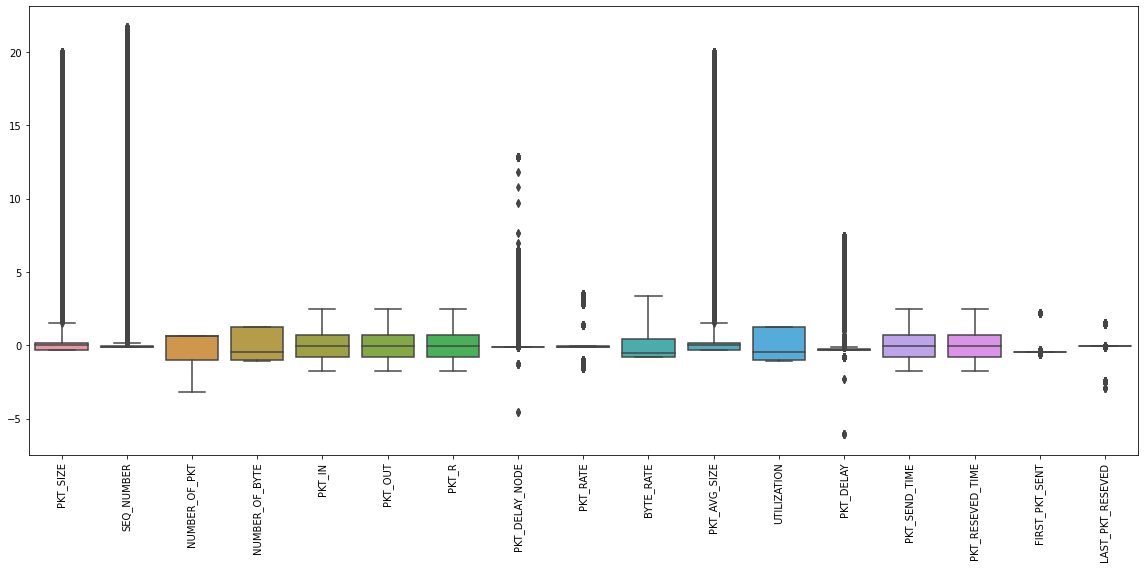

In [113]:
plt.figure(figsize=(16,8))
sns.boxplot( data = df_X_scaled, whis= 3.0 )
plt.xticks(rotation=90)  
plt.tight_layout()

The box plots show that same features hava some outliners but those outliners could be normal when the network is under attack since some of the malicious attacks are direct to overflows the network either with many requests or by requesting very large packages to overload the system. Therefore, I am not delete those outliners since that could be vital to classify some of the malicious attacks.

### 2.3.4 PCA Scatter Plot

In [114]:
pca2d = PCA(n_components=2)

pc = pca2d.fit_transform(df_scaled.iloc[:,:-1].values)

In [115]:
pca2d.explained_variance_ratio_

array([0.34825085, 0.21457388])

In [116]:
pc_df = pd.DataFrame(data = pc , columns = ['PC1', 'PC2'])
pc_df['target'] = df_target
pc_df.target.value_counts()

Normal        310441
UDP-Flood      32138
Smurf           2069
SIDDOS          1069
HTTP-FLOOD       648
Name: target, dtype: int64

In [117]:
pc_df['target_binary'] = df_target
pc_df['target_binary'] = pc_df['target_binary'].replace(to_replace=['Normal', 'UDP-Flood', 'Smurf', 'SIDDOS', 'HTTP-FLOOD'], value=['Normal', 'Malicious','Malicious','Malicious','Malicious'])
pc_df.target_binary.value_counts()

Normal       310441
Malicious     35924
Name: target_binary, dtype: int64

I plot two PCA scatter plots, one with the orginal number of different types of malicious flows and one where I have merged all them in one attack. 

In [118]:
#plt.figure(figsize=(12, 12))
#plt.subplot(2, 2, 1)
#sns.scatterplot(
#    data=pc_df, x="PC1", y="PC2", hue="target", alpha = 0.4)

#plt.title('PCA Scatter Plot')

#plt.subplot(2, 2, 2)
#sns.scatterplot(
#    data=pc_df, x="PC1", y="PC2", hue="target_binary", alpha = 0.4)

#plt.title('PCA Scatter Plot binary')
#plt.show()

Even after merging the malicious attacks in only one type of attacks, the points are not linearly separable as in the case in which the types of attacks are kept separated, since same of the points belonging to a class are overlapped by other points belonging to another class that I make visiable by adding a alpha value in the plots.

## 2.4 check for highly correlated features

### Correlation 

I check for correlation between the features and drop the ones that are highly correlated with other features since those could reduce the perfomance of the claissifier. I select only the numeric features to calculate the correlation without including the first two columns <font color=red>SRC_ADD</font> and <font color=red>DES_ADD</font> since they correspond only to the source and destination of the packeges sent.  

In [119]:
#select only the numeric features
df_corr = df_X[df_X.columns[2:]].select_dtypes(include=['float64','int64'])

In [120]:
df_corr.shape

(864268, 17)

Only 17 out 28 feartures are numeric ones.

#### Plot Seaborn Heatmap

I plot the correlation heatmap from seaborn to check if between the features there are some of them highly correlated. 

peak memory: 7053.43 MiB, increment: 112.23 MiB


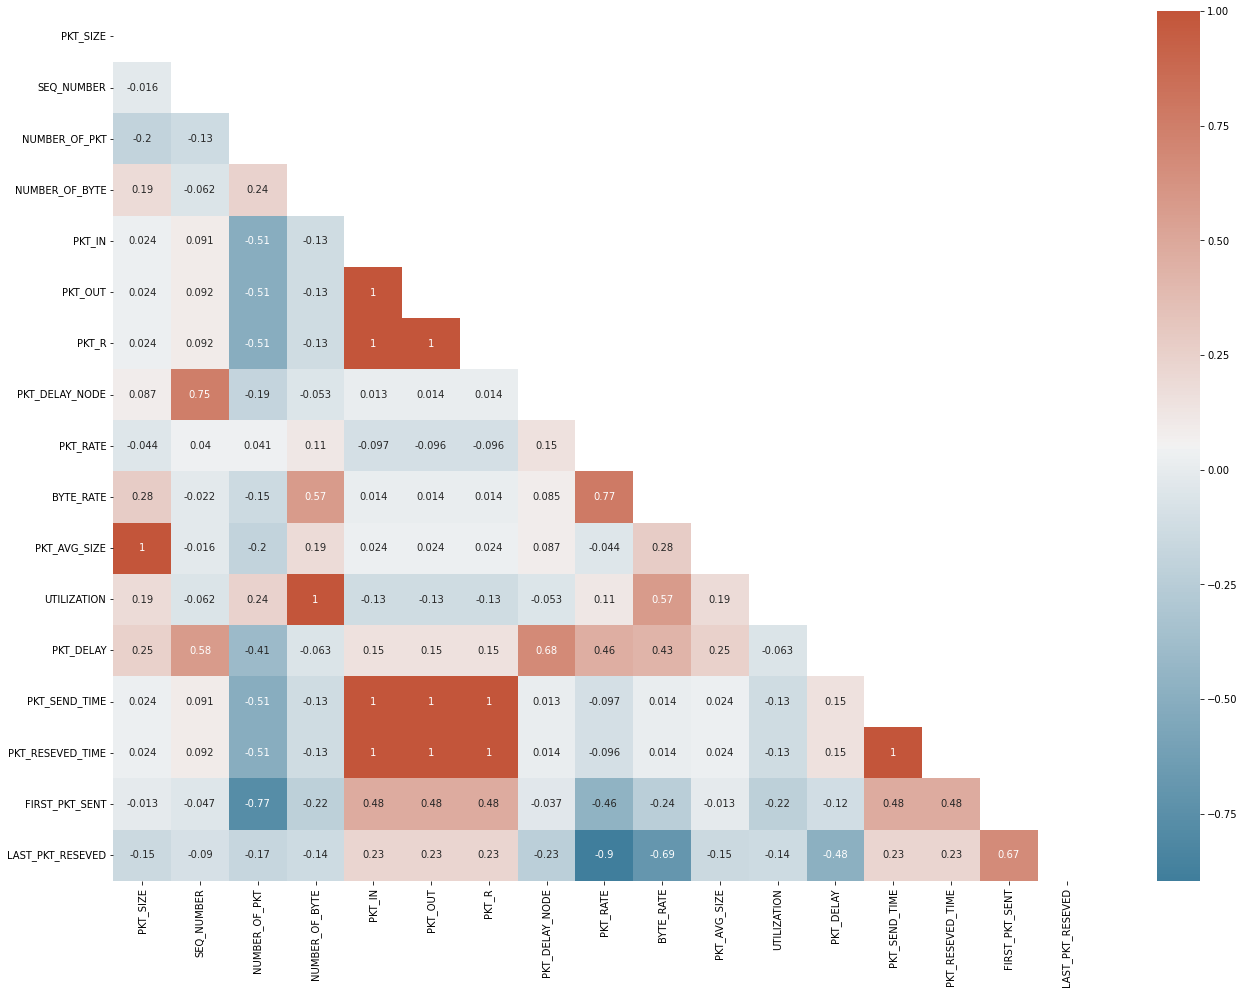

In [121]:
%%memit
fig, ax = plt.subplots(figsize=(22, 16))
corr = df_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

## 2.4.1 Drop highly correlated features

Select and drop the columns that have a correlation above __0.95__.

In [122]:
correlation_matrix = df_corr.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))


to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


['PKT_OUT', 'PKT_R', 'PKT_AVG_SIZE', 'UTILIZATION', 'PKT_SEND_TIME', 'PKT_RESEVED_TIME']


__6 columns are above the threshold:__<br>
<font color=red>PKT_OUT,<br> PKT_R,<br> PKT_AVG_SIZE,<br> UTILIZATION,<br> PKT_SEND_TIME,<br> PKT_RESEVED_TIME</font>.

I drop those features from the original dataset.

I drop also the first two columns <font color=red>SRC_ADD</font> and <font color=red>DES_ADD</font> that are category columns that do not add any important information on the attack flows since they just are the names of the sources and destinations of the request packages. 

In [123]:
#I have excluded the first two columns SRC_ADD and DES_ADD 
df_clean =df_X[df_X.columns[2:]].drop(to_drop, axis = 1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864268 entries, 1896118 to 682597
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PKT_ID            864268 non-null  object 
 1   FROM_NODE         864268 non-null  object 
 2   TO_NODE           864268 non-null  object 
 3   PKT_TYPE          864268 non-null  object 
 4   PKT_SIZE          864268 non-null  int64  
 5   FID               864268 non-null  object 
 6   SEQ_NUMBER        864268 non-null  int64  
 7   NUMBER_OF_PKT     864268 non-null  int64  
 8   NUMBER_OF_BYTE    864268 non-null  int64  
 9   NODE_NAME_FROM    864268 non-null  object 
 10  NODE_NAME_TO      864268 non-null  object 
 11  PKT_IN            864268 non-null  float64
 12  PKT_DELAY_NODE    864268 non-null  float64
 13  PKT_RATE          864268 non-null  float64
 14  BYTE_RATE         864268 non-null  float64
 15  PKT_DELAY         864268 non-null  float64
 16  FIRST_PKT_SENT

In [124]:
df_num = df_clean.select_dtypes(include=['float64','int64'])
#df_target = df_clean[df_clean.columns[-1]]

__I concatenate the features not scaled with the new dummy features FLAGS and the target variable that I will use to train the binary classifier.__ 

In [125]:
df_reduced = pd.concat([df_num, df_X.iloc[:,-2:], df_target], axis=1)

In [126]:
df_reduced.head(2)

PKT_SIZE  SEQ_NUMBER  NUMBER_OF_PKT  NUMBER_OF_BYTE     PKT_IN  \
1896118        55        4821          16103          885665  15.777890   
1959586        64          -1            210           13440   9.118647   

         PKT_DELAY_NODE    PKT_RATE     BYTE_RATE  PKT_DELAY  FIRST_PKT_SENT  \
1896118             0.0  328.432001  18063.800000   0.000000        1.030038   
1959586             0.0   23.255775   1488.369621   0.030015        0.108642   

         LAST_PKT_RESEVED  FLAGS_0  FLAGS_1 PKT_CLASS  
1896118         50.059974        1        0    Normal  
1959586          9.138657        1        0    Normal

# 3. Balance the dataset

## 3.1 Check if the data is unbalanced

### I create a table with frequencies for each class and their percentage over the total types of Network Logs

In [127]:
keys_classes = df_reduced.PKT_CLASS.value_counts().keys()
value_classes = []
percentage_classes = []

for i in range(len(df_reduced.PKT_CLASS.value_counts())):
    value_classes.append(df_reduced.PKT_CLASS.value_counts()[i])
    percentage_classes.append(round(df_reduced.PKT_CLASS.value_counts(normalize=True)[i]*100, 2))   
res = {keys_classes[i]: value_classes[i] for i in range(len(keys_classes))}

df_count = pd.DataFrame.from_dict(res, orient ='index', columns = ['Frequency'])
df_count['Percentage'] = percentage_classes
(df_count.style.background_gradient(subset=['Frequency', 'Percentage'], cmap='cividis')
 .format({'Frequency': '{}', 'Percentage': '{}%'}))


### The dataset is extremely unbalanced as expected since most of the time the network is not under attack. 

## 3.2 Merge Malicious Flows in one category

#### Binary labels 
I merge all the malicious network flows in only one attack.
To Normal Network flows, I assign 0 and 1 for Malicious Network flows.

In [128]:
df_reduced['PKT_CLASS'] = df_reduced['PKT_CLASS'].replace(to_replace=['Normal', 'UDP-Flood', 'Smurf', 'SIDDOS', 'HTTP-FLOOD'], value=[0, 1, 1,1,1])

I split the target feature from the other features.

In [129]:
df_target = df_reduced[df_reduced.columns[-1]] 

In [130]:
df_X_reduced = df_reduced.iloc[:,:-1]

In [131]:
df_X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864268 entries, 1896118 to 682597
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   PKT_SIZE          864268 non-null  int64  
 1   SEQ_NUMBER        864268 non-null  int64  
 2   NUMBER_OF_PKT     864268 non-null  int64  
 3   NUMBER_OF_BYTE    864268 non-null  int64  
 4   PKT_IN            864268 non-null  float64
 5   PKT_DELAY_NODE    864268 non-null  float64
 6   PKT_RATE          864268 non-null  float64
 7   BYTE_RATE         864268 non-null  float64
 8   PKT_DELAY         864268 non-null  float64
 9   FIRST_PKT_SENT    864268 non-null  float64
 10  LAST_PKT_RESEVED  864268 non-null  float64
 11  FLAGS_0           864268 non-null  uint8  
 12  FLAGS_1           864268 non-null  uint8  
dtypes: float64(7), int64(4), uint8(2)
memory usage: 113.0 MB


## 3.3 Split the dataset in two sets

I split that dataset in two sets, one for training and the other one for testing. The size of test dataset is the 33% of the whole dataset. I am not stratifying the data since there is no need to do it. There are only two clasess and the minority class is very numerous. 

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df_X_reduced, df_target, 
                                                    test_size=0.33, random_state=42)

In [133]:
X_test

PKT_SIZE  SEQ_NUMBER  NUMBER_OF_PKT  NUMBER_OF_BYTE     PKT_IN  \
2121596        55        7648          16091          885005  24.320261   
658839        692         275           9108         6302740   7.606720   
642604         55         585          16090          884950   3.009107   
1415223      1000        1842           6250         6250000  39.736000   
1612379        55        4170          16088          884840  13.830236   
...           ...         ...            ...             ...        ...   
429200         55       15856          16103          885665  49.312571   
1434482       576     2919057           5628         3241730  51.670672   
1781515      1540       11936          16091        24780100  37.368229   
795419        576      317849           7110         4095360  59.492495   
330250         55         385          16091          885005   2.406818   

         PKT_DELAY_NODE     PKT_RATE  BYTE_RATE  PKT_DELAY  FIRST_PKT_SENT  \
2121596        0.000000   328.264120    18054.5   0.000000        1.030022   
658839         0.003776  1016.549170   703452.0   0.037694        1.000000   
642604         0.000000   328.167767    18049.2   0.000000        1.030051   
1415223        0.000000   124.941627   124942.0   0.001258       25.000000   
1612379        0.000000   328.113525    18046.2   0.000000        1.030054   
...                 ...          ...        ...        ...             ...   
429200         0.000000   328.460278    18065.3   0.000000        1.030032   
1434482        0.114464   658.090443   379060.0   0.153680        1.447776   
1781515        0.000000   328.192835   505416.0   0.000000        1.000000   
795419         0.000000    95.145988    54804.1   0.113037        1.272550   
330250         0.000000   328.316229    18057.4   0.000000        1.030010   

         LAST_PKT_RESEVED  FLAGS_0  FLAGS_1  
2121596         50.048477        1        0  
658839           9.959724        1        0  
642604          50.059851        1        0  
1415223         75.023360        1        0  
1612379         50.061864        1        0  
...                   ...      ...      ...  
429200          50.055747        1        0  
1434482          9.999792        1        0  
1781515         50.029102        1        0  
795419          75.999821        1        0  
330250          50.040685        1        0  

[285209 rows x 13 columns]

In [134]:
print(f'Number of Normal flows {y_train.value_counts()[0]} and number attacks {y_train.value_counts()[1]} of the Training dataset')

Number of Normal flows 518790 and number attacks 60269 of the Training dataset


In [135]:
print(f'Number of Normal flows {y_test.value_counts()[0]} and number attacks {y_test.value_counts()[1]} of the Test dataset')

Number of Normal flows 255594 and number attacks 29615 of the Test dataset


## 3.4 SMOTE technique to balance the train dataset

To balance the dataset I have employed a technique that oversamples the minority class called __Synthetic Minority Oversampling Technique__ (SMOTE) (Chawla, Bowyer, Hall, & Kegelmeyer, 2002). The figures  below depict how this technique works. From figure on the left hand side, This technique locates the data points of the minority class and draws new synthetic examples ‘along the line segments joining any/all of the k minority class nearest neighbours’.

#### Over-sampling to balance training dataset

## 3.5 Split the train dataset for validation use

For the test harness, I use oly <font color=blue>10%</font> of the training data as validation dataset and the same set of data points is used to tune the hyperparameters.

In [136]:
X_val_bal_sample, X_train_bal, y_val_bal_sample, y_train_bal = train_test_split(X_train_bal, y_train_bal, 
                                                    test_size=0.90, random_state=42)

In [137]:
X_val_bal_sample.shape

(93382, 13)

I have selected three learning algorthms, namely Logistic regression, Decison Tre and eXtreme Gradient Boosting (XGBoost) algorithms.
I use a pipeline of each learning algorithm chosen in which I have tested the perfomance of those algorithms when using either scaled or not scaled datapoints. As a scaler, I use the StandardScaler. 

In [138]:
def test_harness(models,X_train,y_train, splits):
    
    """
        A test harness used to spot check the best model using different metrics
            Accuracy
            Fi_score
            Recall
            Precision
        It runs 4 - the number metrics - times the number of the split for each model and save
        the mean value of each metric score. 
        Parmeters: 
            models = list of pipelines with different classifiers
            X_train and y_train = respectively pandas dataframe for the features and target series
            splits = num of Kfold
        Return:
           db_results = dataframe of the mean results for each metric scores for each classifier 
           results = the score values for each iteraction
    """
    #for the parameters scoring 
    scoring_acc = metrics.make_scorer(metrics.accuracy_score)
    scoring_prec = metrics.make_scorer(metrics.precision_score)
    scoring_rec = metrics.make_scorer(metrics.recall_score)
    scoring_f1 = metrics.make_scorer(metrics.f1_score)

    score_list = []
    score_list.append(scoring_acc)
    score_list.append(scoring_prec)
    score_list.append(scoring_rec)
    score_list.append(scoring_f1)

    names_score = ['acc', 'prec', 'rec', 'f1']
    name_score_model = []

    #to store results of cv in a data set
    results_std = []
    results_mean = []
    results = []
    time_models =[]

    for name, model in models:
        for score, name_score in zip(score_list, names_score):
            kfold = KFold(n_splits=splits)

            #timing the model
            start = time.time()
            #cross validation
            results_cv = cross_val_score(model, X_train, y_train, cv=kfold, scoring= score)
            end = time.time()

            #save the results metrics
            results_mean.append(round(results_cv.mean(),5))
            results_std.append(round(results_cv.std(),5))
            results.append(results_cv)
            time_models.append(round(end - start, 5))
            name_score_model.append((name, name_score))
            print('model :', name, '-' ' time :',str(round(end - start, 5)))

    name_dict_db_results = [' '.join(map(str,name_score_model[i])) for i in range(len(name_score_model))]
    dictionary_results = {'Model': name_dict_db_results, 'Mean': results_mean, 'Std': results_std, 'time_models' :time_models } 
    db_results = pd.DataFrame(dictionary_results)
    
    return db_results, results 
#Adapted from - Brownlee, J. (2016) Machine learning mastery with Python: understand your data, create accurate models, and work projects end-to-end.

## 4.1 Pipelines of learning algorithms

__I set the pipelines with and without scaling the datapoints.__
I choose three leanring algorithms:
<br>`Logistic Regression`
<br>`Decision Tree`
<br>`RandomForest`

In [139]:
#pipelines of the models with different vectorization methods
logi_model = Pipeline([('LOGI', LogisticRegression(random_state = 0, n_jobs=-1))])
logi_model_sc = Pipeline([('scale', StandardScaler()),('LOGI', LogisticRegression(random_state = 0, n_jobs=-1))])
DCT_model =  Pipeline([('DCT',DecisionTreeClassifier(random_state=0))])
DCT_model_sc =  Pipeline([('scale', StandardScaler()),('DCT',DecisionTreeClassifier(random_state=0))])
RFC_model = Pipeline([('RFC', RandomForestClassifier(n_jobs=-1))])
RFC_model_sc = Pipeline([('scale', StandardScaler()),('RFC', RandomForestClassifier(n_jobs=-1))])

models = []
models.append(('LOGI', logi_model))
models.append(('LOGI_SC', logi_model_sc))
models.append(('DCT', DCT_model))
models.append(('DCT_SC', DCT_model_sc))
models.append(('RFC', RFC_model))
models.append(('RFC_SC', RFC_model_sc))

In [140]:
db_results, results = test_harness(models, X_val_bal_sample, y_val_bal_sample, 5)

model : LOGI - time : 6.68121
model : LOGI - time : 6.70665
model : LOGI - time : 6.70074
model : LOGI - time : 6.6225
model : LOGI_SC - time : 7.63448
model : LOGI_SC - time : 7.7616
model : LOGI_SC - time : 7.75886
model : LOGI_SC - time : 7.80118
model : DCT - time : 2.32226
model : DCT - time : 2.25398
model : DCT - time : 2.26055
model : DCT - time : 2.28445
model : DCT_SC - time : 2.28735
model : DCT_SC - time : 2.31865
model : DCT_SC - time : 2.28194
model : DCT_SC - time : 2.29051
model : RFC - time : 17.73956
model : RFC - time : 17.20099
model : RFC - time : 17.62252
model : RFC - time : 17.41789
model : RFC_SC - time : 17.2149
model : RFC_SC - time : 16.70473
model : RFC_SC - time : 17.03063
model : RFC_SC - time : 16.82415


In [141]:
db_results

Model     Mean      Std  time_models
0       LOGI acc  0.91917  0.00111      6.68121
1      LOGI prec  0.99782  0.00047      6.70665
2       LOGI rec  0.84041  0.00204      6.70074
3        LOGI f1  0.91238  0.00124      6.62250
4    LOGI_SC acc  0.93441  0.00158      7.63448
5   LOGI_SC prec  0.99518  0.00106      7.76160
6    LOGI_SC rec  0.87325  0.00258      7.75886
7     LOGI_SC f1  0.93023  0.00158      7.80118
8        DCT acc  0.95661  0.00133      2.32226
9       DCT prec  0.95826  0.00191      2.25398
10       DCT rec  0.95494  0.00197      2.26055
11        DCT f1  0.95660  0.00137      2.28445
12    DCT_SC acc  0.95370  0.00162      2.28735
13   DCT_SC prec  0.95606  0.00166      2.31865
14    DCT_SC rec  0.95124  0.00178      2.28194
15     DCT_SC f1  0.95365  0.00159      2.29051
16       RFC acc  0.96248  0.00116     17.73956
17      RFC prec  0.97294  0.00147     17.20099
18       RFC rec  0.95122  0.00196     17.62252
19        RFC f1  0.96213  0.00108     17.41789
20    RFC_SC acc  0.96173  0.00137     17.21490
21   RFC_SC prec  0.97637  0.00144     16.70473
22    RFC_SC rec  0.94727  0.00140     17.03063
23     RFC_SC f1  0.96127  0.00072     16.82415

## 4.2 Spot-check the best model using Box and Whiskers Plots

I split the different results by the learning algorithm so I can plot the results in a single plot for each of those algorithms. 

In [142]:
values = pd.DataFrame()
ls_log = [0,1,2,3,4,5,6,7]
ls_dc = [8,9,10,11,12,13,14,15]
ls_rf = [16,17,18,19,20,21,22,23]

res_log = []
res_dc=[]
res_rf=[]
for i in range(24):
    if i in ls_log:
        da = results[i]
        res_log.append(da)
    if i in ls_rf:
        da = results[i]
        res_rf.append(da)
    if i in ls_dc:
        da = results[i]
        res_dc.append(da)

### Boxplots of the different learning algorithms of the test harness
The boxplot helps to spot check and select the best algorithm based by its performance and the variance of its perfomance over the different folds. 

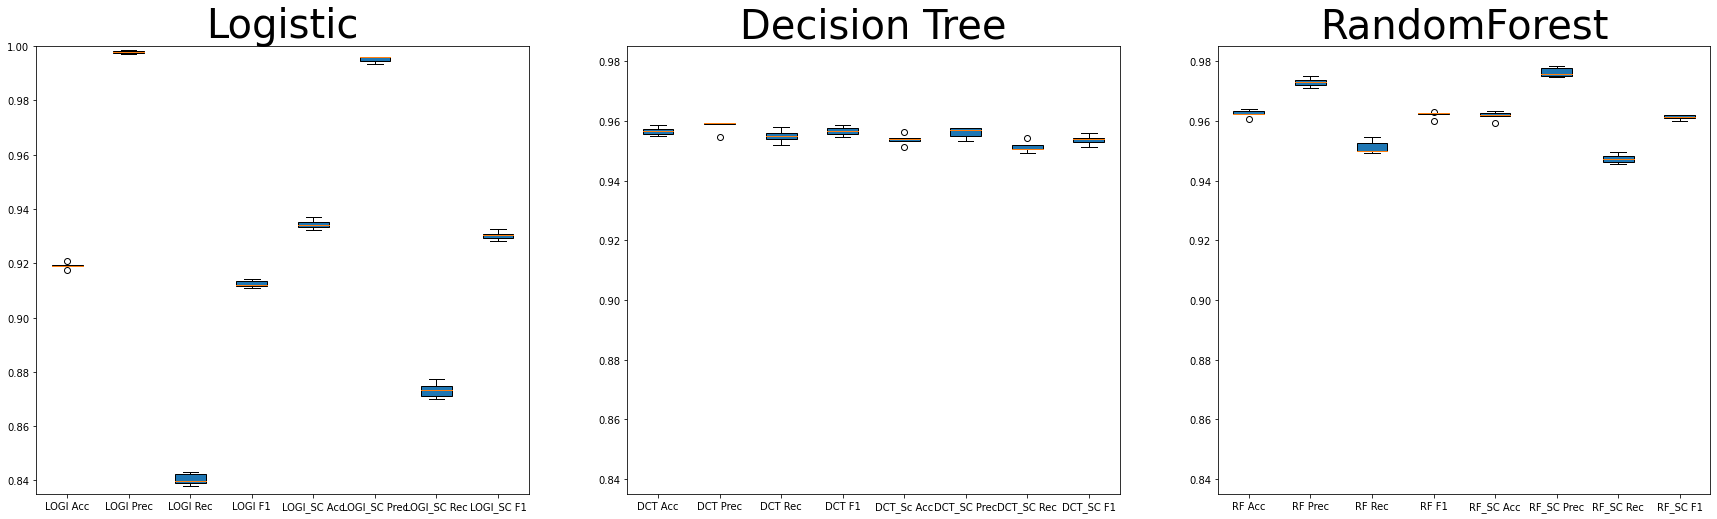

In [143]:
plt.figure(figsize=(30,28))

plt.subplot(3, 3, 1)
plt.title("Logistic",fontsize=40)
plt.ylim(0.835, 1)
plt.boxplot(res_log,patch_artist=True,
                  labels=['LOGI Acc','LOGI Prec','LOGI Rec' ,'LOGI F1', 'LOGI_SC Acc','LOGI_SC Prec','LOGI_SC Rec' ,'LOGI_SC F1'])

plt.subplot(3, 3, 2)
plt.title("Decision Tree",fontsize=40)
plt.ylim(0.835,0.985)
plt.boxplot(res_dc,patch_artist=True,
                  labels=['DCT Acc','DCT Prec', 'DCT Rec', 'DCT F1','DCT_Sc Acc','DCT_SC Prec', 'DCT_SC Rec', 'DCT_SC F1'])
                          
plt.subplot(3, 3, 3)
plt.title("RandomForest",fontsize=40)
plt.ylim(0.835, 0.985)
plt.boxplot(res_rf,patch_artist=True,
                  labels=['RF Acc','RF Prec', 'RF Rec', 'RF F1','RF_SC Acc','RF_SC Prec', 'RF_SC Rec', 'RF_SC F1'])        
plt.show()

Decision Tree has a more stable performance than the other two algorithm but RandomForest with data not scaled has slightly a better performance with a higher F1-Score and Precision scores than the Decision Tree model. Therefore, I opt to train the binary classifier using the RandomForest algorithm with unscaled data. The training would be conducted using a larger datasest - only 10% of training data was used for the test hareness - that would help the RandomForest algorithm to outperform a simple Decision Tree algorithm. 
N.B. The Logistic plot has a different maximum set for the y-axis. 

# 5. Training phase

## 5.1 Train the best learning algorithm

__The function below returns the evaluation metrics for a binary classification.__

In [144]:
def calc_binary_class_metrics(targets, model, name_model, data_type):


    """The function returns the evaluation metrics for a binary
    classification - Class 1.
    
    Parameters
    ----------
    targets : target variable
    model : model fit and trained that needs to be evaluated
    name_model : string name of the learning algorithm
    data_type : string name of the type of data used to eveluate the model - test or validation
    
    Returns
    -------
    a dataset with all the metrics stored in one row 
    
    """
    # Metrics
    precision = metrics.precision_score(targets, model)
    recall = metrics.recall_score(targets, model)
    f1_score = metrics.f1_score(targets, model)
    balanced_accuracy = metrics.balanced_accuracy_score(targets, model)
    accuracy = metrics.accuracy_score(targets, model)

    #to calculate AUC for multiclass
    auc = metrics.roc_auc_score(targets, model)

    #calculate specificity
    m_c = metrics.confusion_matrix(targets, model)
    tn = m_c[0, 0]
    tp = m_c[1, 1]
    fn = m_c[1, 0]
    fp =m_c[0, 1]
    #https://scikit-learn.org/stable/modules/model_evaluation.html
    specificity = tn / (tn + fp)

    #creates the dictionar to be saved in the results_score data frame
    scores = {
         'Model': [name_model],
        'Data' : [data_type],
         'Precision': [precision],
         'Recall': [recall],
        'Specificity' : [specificity],
        'F1-score' : [f1_score],
        'Accuracy': [accuracy],
        'Bal Accuracy' : [balanced_accuracy],
        'AUC' : [auc]
    }

    scores = pd.DataFrame(scores)
    
    return scores

__Initialisation dataset to store all the results.__

In [145]:
results_score = pd.DataFrame()

### 5.1.1 Traing without tuning the parameters

First, __I train the learning algorithm without tuning its hyperparamters.__

In [146]:
import joblib

# Load the saved model
loaded_model = joblib.load("/kaggle/input/dddos-model/random_forest_model.pkl")




In [147]:
column_names = X_test.columns
column_names

Index(['PKT_SIZE', 'SEQ_NUMBER', 'NUMBER_OF_PKT', 'NUMBER_OF_BYTE', 'PKT_IN',
       'PKT_DELAY_NODE', 'PKT_RATE', 'BYTE_RATE', 'PKT_DELAY',
       'FIRST_PKT_SENT', 'LAST_PKT_RESEVED', 'FLAGS_0', 'FLAGS_1'],
      dtype='object')

In [148]:
# Check the lengths of X_test and y_test
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))

# If they don't match, you need to align them
# Assuming y_test is a pandas Series and X_test is a pandas DataFrame
# We can align them by resetting the index of X_test and y_test
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Now, check the lengths again to ensure they match
print("Length of X_test after alignment:", len(X_test))
print("Length of y_test after alignment:", len(y_test))

# Now, you can proceed with making predictions and evaluating the model
rf_test_pred = loaded_model.predict(X_test)

print("Accuracy on test data: \n", metrics.accuracy_score(y_test, rf_test_pred))
print("Classification report: \n", metrics.classification_report(y_test, rf_test_pred))
print('Confusion Matrix test: \n' + str(metrics.confusion_matrix(y_test, rf_test_pred)))


Length of X_test: 285209
Length of y_test: 285209
Length of X_test after alignment: 285209
Length of y_test after alignment: 285209
Accuracy on test data: 
 0.9769362116903745
Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    255594
           1       0.90      0.87      0.89     29615

    accuracy                           0.98    285209
   macro avg       0.94      0.93      0.94    285209
weighted avg       0.98      0.98      0.98    285209

Confusion Matrix test: 
[[252739   2855]
 [  3723  25892]]


In [166]:
predictions = loaded_model.predict(X_test)


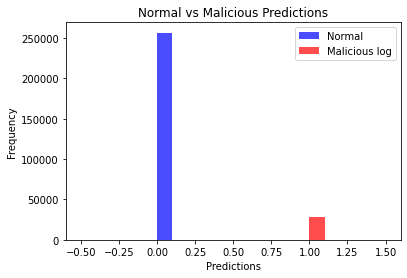

In [168]:
import matplotlib.pyplot as plt

# Assuming predictions contains 0 for malicious and 1 for normal
normal_predictions = predictions[predictions == 0]
malicious_predictions = predictions[predictions == 1]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plotting the normal predictions
ax.hist(normal_predictions, color='blue', alpha=0.7, label='Normal')

# Plotting the malicious predictions
ax.hist(malicious_predictions, color='red', alpha=0.7, label='Malicious log')

# Adding labels and legend
ax.set_xlabel('Predictions')
ax.set_ylabel('Frequency')
ax.set_title('Normal vs Malicious Predictions')
ax.legend()

# Display the plot
plt.show()
